<div align="right" style="text-align: right"><i>Peter Norvig<br>Aug 2020<br>Revised Jun 2025</i></div>

# War [(What is it Good For?)](https://www.youtube.com/watch?v=bX7V6FAoTLc)

The [538 Riddler Classic for 28 August 2020](https://fivethirtyeight.com/features/can-you-cover-the-globe/) concerns the children's [**card game War**](https://en.wikipedia.org/wiki/War_%28card_game%29). The column states "Duane’s friend’s granddaughter claimed that she once won a game of War that lasted exactly 26 turns, with no wars." What is the probability of that? We'll analyze this problem, and then we'll look at some other questions about the game. To review, here are the rules:
- The deck (typically 52 cards) is dealt out so that the two players each have half the cards (26).
- Both players play a card, face up, from the top of their deck. This is called a **battle**.
- If there is a tie between the two cards in a battle, a **war** ensues:
    - To resolve a war, both players play three cards face down and a fourth face up. (Some variants use only one or two face-down cards.)
    - If the fourth (face-up) cards are the same, there is another war.
- The player with the higher of the face-up cards wins the battle/war and places all the played cards at the bottom of their deck (in random order).
- Repeat play until one player runs out of cards, and thereby loses the game.
    - If both players run out of cards at the same time, it is a tie.

I considered four approaches:

# Approach 1: Simple Arithmetic?

Assuming the cards are fairly shuffled, both players have an equal chance of winning each battle. If player **A** wins each battle with probability 1/2, than the probability of sweeping 26 battles in a row would be:

In [1]:
(1/2) ** 26

1.4901161193847656e-08

About **15 in a billion**. But after player **A** plays a card, there are 51 possible cards that player **B** might play. Of these, 3 have the same rank as **A**'s card, resulting in a tie. So the possible outcomes for the first battle are:    

    tie:     3/51
    A wins: 24/51
    B wins: 24/51
    
If every subsequent battle were the same, the probability that **A** sweeps 26 battles in a row would be:

In [2]:
(24/51) ** 26

3.0808297965386556e-09

About **3 in a billion**.  I have to say, I'm begining to doubt Duane’s friend’s granddaughter's claim! 

But this answer is still not quite right because the outcome of each battle depends on the cards played in the previous turns. So simple arithmetic gets us an estimate, but not an exact answer.

# Approach 2: Brute Force Enumeration?

A discrete probability problem like this can be solved, in theory, by enumerating every possibility:
- Consider every possible permutation (that is, shuffle) of the deck of cards.
- For each permutation, deal out the cards and see whether or not **A** wins every battle.
- The probability is the number of sweeps divided by the number of permutations.

Easy-peasy; here's the code (with some imports first):

In [3]:
import random
import matplotlib.pyplot as plt
from collections import Counter, deque, namedtuple
from itertools   import permutations, combinations, count as count_from
from statistics  import mean, median, stdev, mode
from typing      import List, Tuple, Iterable

In [4]:
Probability = float # Type: Probability is a number between 0.0 and 1.0
Deck        = deque # Type: Deck is a sequence of card ranks

def make_deck(ranks=13, suits=4) -> Deck: 
    """A Deck is a sequence of ranks, each rank repeated `suits` times."""
    return Deck(r for r in range(1, ranks + 1) for _ in range(suits)) 

deck52 = make_deck(13, 4)

def is_sweep(deck: Deck) -> bool: 
    """Upon dealing this deck, does player A win every battle?"""
    return all(deck[i] > deck[i + 1] for i in range(0, len(deck), 2))

def p_sweep(decks: Iterable[Deck]) -> Probability:
    """The probability that player A sweeps every battle, averaged over the decks."""
    return mean(map(is_sweep, decks))

(*Implementation details:* in Python `False` is equivalent to `0` and `True` is equivalent to `1`, so the `mean` of an iterable of `bool` values is the same as the proportion (or probability) of `True` values. I used a `deque` (doubly-ended queue) to represent a deck, because I think of a deck as popping cards off the top and adding cards to the bottom (although we won't add to the bottom until later). Also because "deck" and "deque" are homophones.)

Here are three different 8-card decks:

In [5]:
assert make_deck(ranks=8, suits=1) == Deck([1, 2, 3, 4, 5, 6, 7, 8])
assert make_deck(ranks=4, suits=2) == Deck([1, 1, 2, 2, 3, 3, 4, 4])
assert make_deck(ranks=2, suits=4) == Deck([1, 1, 1, 1, 2, 2, 2, 2])

And here are the probabilities of sweeping a game played with those decks:

In [6]:
p_sweep(permutations(make_deck(8, 1)))

0.0625

In [7]:
p_sweep(permutations(make_deck(4, 2)))

0.03571428571428571

In [8]:
p_sweep(permutations(make_deck(2, 4)))

0.014285714285714285

What about the real deck, with 52 cards? Unfortunately, there are 52! permutations (more than $10^{67}$), and even if we were clever about repetitions, and
even if we could process a billion deals a second, it would still take [millions of years](https://www.google.com/search?q=%2852%21+%2F+4%21%5E13+%2F+26%21%29+nanoseconds+in+years&oq=%2852%21+%2F+4%21%5E13+%2F+26%21%29+nanoseconds+in+years) to complete the brute force enumeration. And 538 Riddler wanted the answer by Monday!



# Approach 3: Random Simulation?

It takes too long to look at **all** the permutations, but we can  randomly sample **some** of the permutations of the deck to get an estimated probability. With enough samples this estimate will be close to the true value. The function `shuffles` yields `n` random shuffles of a deck:

In [9]:
def shuffles(deck: Deck, n: int) -> Iterable[Deck]:
    """`n` random shuffles (mutations) of `deck`."""
    for _ in range(n):
        random.shuffle(deck)
        yield deck

def shuffle(deck: Deck) -> Deck:
    """A single shuffle of `deck`."""
    return next(shuffles(deck, 1))

The following sample is close to the true value of 0.0625:

In [10]:
p_sweep(shuffles(make_deck(8, 1), 100_000))

0.06233

We can handle the full 52 card deck, but will the estimate be accurate?

In [11]:
p_sweep(shuffles(deck52, 100_000))

0

The estimate is **0 in 100,000** which is the best possible estimate with that few samples. We  would need trillions of samples to get a decent estimate. That would require weeks of run time: much better than millions of years, but still not good enough. 

# Approach 4: Abstract Incremental Enumeration

As discussed in my [**How To Count Things**](How%20To%20Count%20Things.ipynb) notebook, in problems where brute force enumeration is not feasible it is often possible to use a representation that is:
- **Incremental**: First we'll consider the possibilities for the two cards in the first battle, and only for the outcomes in which **A** wins will we then move on to look at the possible cards for the next battle. For outcomes in which **A**  loses or ties, there is no need to consider the permutations of the remaining cards.
- **Abstract**: What matters on each battle is whether **A**'s next card is higher, lower, or the same as **B**'s next card. On the first battle there are 52 × 3 = 156 ways in which the two players could play the same rank, but it doesn't matter if the ranks are two 3s or two 7s or whatever; the result is the same. So we should have an abstract representation that treats this as one way, not 156. Similarly, there are 52 × 48 = 2496 ways in which the two players could play different ranks, but again it doesn't matter if this is a 3 and a 7; or a 2 and a 10, or whatever. 

     
# Abstract Deck

The representation I will use, which I call `AbstractDeck`, is as follows:
- An `AbstractDeck` is a tuple of counts of the number of remining cards of each rank, without specifying the ranks. 
- Ranks with counts of zero are dropped from the representation.
- The counts are put in sorted order, lowest counts first.
- For example:
    - The initial 52-card deck is 13 ranks of 4 cards each: `(4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4)`
    - The possible decks with just 2 cards remaining are `(2,)` and `(1, 1)`; that is, two cards of the same rank or 1 each of two different ranks.
    - The possible decks with just 3 cards remaining are `(1, 1, 1)`, `(1, 2)`, and `(3,)`.

In [12]:
AbstractDeck = tuple # Type: An abstract deck

deck52a = AbstractDeck(13 * [4]) # The initial 52-card abstract deck
deck52a

(4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4)

>***Note:***  I also thought of an alternative representation in which: 
>- A deck was a tuple where `deck[i]` gives the number of different ranks that have exactly `i` cards remaining in the deck.
>- The initial deck is represented as `(0, 0, 0, 0, 13)`: 13 ranks with 4-of-a-kind; none with less than that.
>- The two possible two-card decks are `(0, 2)` (two ranks with 1 card each) and `(0, 0, 1)` (one rank with two cards).
>
>That representation was more compact, and thus ran a bit faster. But the very nice  [implementation](https://laurentlessard.com/bookproofs/flawless-war/) shared by [Laurent Lessard](https://laurentlessard.com/) convinced me to show the `AbstractDeck` representation because it is simpler to code and to understand.

# Probability Distribution

We'll keep track of possible outcomes with a class called `ProbDist` (for **probability distribution**), a mapping of `{deck: p}` where `deck` is an abstract deck and `p` is the probability of that deck being the outcome of a battle. For our problem we only need to track the outcomes in which **A** wins.

In [13]:
class ProbDist(Counter): 
    """A probability distribution of {outcome: probability}."""

# Abstract Incremental Enumeration Strategy

The probability that **A** sweeps a game of War, `p_sweep_abstract(deck)`, is computed as follows:

- Start with `P` being a **probability distribution** of outcomes after 0 battles: `{deck: 1.0}`.
- **for** each battle of the game (26 battles for a 52-card deck):
  - Update `P` to be the distribution that results from playing a single battle, `P = play_battle(P)`. Do that as follows:
  - **for** each `deck` in `P`:
      - **for** each way of removing two cards of distinct ranks `i` and `j` from `deck` to yield a resulting deck:
          - Increment the probability of the resulting deck by probability of `deck` × probability of  `i` ×  probability of `j` 

Note that the call `combinations(indexes, 2)` yields all distinct pairs of indexes. Thus it will return `(i, j)` but not also `(j, i)`, and not `(i, i)`. That's just what we want: if the two selected ranks are the same then the result will be a tie, which we don't want in our resulting distribution of winning outcomes. And out of the two possibilities `(i, j)` and `(j, i)`, exactly one will result in a win for **A**, so we only want to include one of them.

In [14]:
def p_sweep_abstract(deck: AbstractDeck) -> Probability:
    """The probability that player A sweeps every battle in a game of War."""
    P = ProbDist({deck: 1.0}) # The initial probability distribution
    for _ in range(sum(deck) // 2):
        P = play_battle(P)
    return P[()]

def play_battle(P: ProbDist) -> ProbDist:
    """Play one battle with all possible card choices for players A and B; return
    the probability distribution of outcomes where A still might sweep."""
    P1 = ProbDist() # The probability distribution of {deck: prob} after this battle
    for deck in P:
        n = sum(deck) # number of cards in deck
        indexes = range(len(deck))
        for i, j in combinations(indexes, 2):
            P1[remove(deck, i, j)] += P[deck] * deck[i] * deck[j] / (n * (n - 1))
    return P1

def remove(deck: AbstractDeck, i: int, j: int) -> AbstractDeck:
    """Remove a card from each of the indexes i and j from the abstract deck."""
    counts = list(deck)
    counts[i] -= 1
    counts[j] -= 1
    return AbstractDeck(sorted(c for c in counts if c > 0))

In [15]:
assert remove(AbstractDeck((2, 3, 4)), 0, 1) == AbstractDeck((1, 2, 4)) # Test: remove a card from indexes 0 and 2.

# The Answer!

What's the probability that player **A** will win in a sweep?

In [16]:
p = p_sweep_abstract(deck52a)
p

3.132436174322299e-09

A little over **3.1 in a billion** (which is slightly higher than the simple arithmetic calculation).

(By the way, this computation took about 0.07 seconds, a big improvement over millions of years!) 

That's the answer to *my* question about the probability of **A** sweeping, but 538 Riddler actually posed the question somewhat differently: "*How many games of War would you expect to play until you had a game that lasted just 26 turns with no wars, like Duane’s friend’s granddaughter?*" That is, they want to know the inverse of the probability, and they are allowing for either **A** or **B** to sweep. So that would be:

In [17]:
1 / (2 * p)

159620171.70491105

 We would expect a sweep about once every 160 million games.

# Working through the Algorithm

Let's work through how `play_battle` works. We'll start with `P` being the initial probability distribution over possible decks, and then play four battles, each time displaying how `P` is updated.

At the start of the game there is only one possibility: a deck with 13 suits of 4 cards each:

In [18]:
P = ProbDist({deck52a: 1.0})
P

ProbDist({(4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4): 1.0})

Now play one battle:

In [19]:
P = play_battle(P) # Battle 1
P

ProbDist({(3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4): 0.47058823529411703})

There is still only one possibility. That makes sense: the only result where **A** still has a chance to sweep is when the two players turned over cards of different ranks, giving us two ranks with three-of-a-kind remaining, and 11 ranks with four-of-a-kind remaining. The probability of **A** winning one battle is 24/51 = 0.47058823529411703.

For the second battle, here are the possibilities, depending on what card rank each player plays:

|**A**|**B**|**Result**|
|-----|-----|----------|
|3-card rank|same 3-card rank|tie; not in result P|
|4-card rank|same 4-card rank|tie; not in result P|
|3-card rank|different 3-card rank|(2, 2, 4, 4, ...)|
|4-card rank|different 4-card rank|(3, 3, 3, 3, 4, 4, ...)|
|3-card rank|4-card rank|(2, 3, 3, 4, 4, ...)
|4-card rank|3-card rank|(2, 3, 3, 4, 4, ...)



In [20]:
P = play_battle(P) # Battle 2
P

ProbDist({(3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4): 0.16902761104441777,
          (2, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4): 0.050708283313325234,
          (2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4): 0.0017286914765906338})

We'll leave it as an exercise for the reader to verify that the next battle is correct:

In [21]:
P = play_battle(P) # Battle 3
P

ProbDist({(2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4): 0.048550484023396547,
          (3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4): 0.043155985798574735,
          (2, 2, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4): 0.010114684171540947,
          (1, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4): 0.0017981660749406111,
          (1, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4): 0.0004045873668616376,
          (2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4): 0.00020229368343081878,
          (1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4): 3.065055809557861e-06})

# Gaining Confidence in the Answer

One way to gain confidence: The answer should be close to the arithmetic calculation of $(24/51)^{26}$. Let's compute the ratio of the two probabilities:

In [22]:
p  = p_sweep_abstract(deck52a) 
p2 = (24/51) ** 26
p / p2

1.0167508045532485

We see that the two computations are indeed close, differing by 1.675%.

Another way to gain confidence: We can verify that there is no difference between the brute force `p_sweep` and the abstract incremental `p_sweep_abstract` for small decks.  That is evidence that the two implementations are either both right, or both wrong in the same way. `p_sweep` takes just a few milliseconds to solve decks of 8 cards or less, but takes about a second to do the 10! (almost 4 million) permutations of ten card decks, so we won't go larger than that while trying combinations of ranks and suits. In all the cases, the two probability calculations are the same (at least for 16 digits).

In [23]:
biggest_deck = 10

sizes = [(r, s) for r in range(2, biggest_deck + 1) for s in range(1, biggest_deck + 1)
                if r * s <= biggest_deck and (r * s) % 2 == 0]

for (r, s) in sizes:
    p1 = p_sweep(permutations(make_deck(r, s)))
    p2 = p_sweep_abstract(AbstractDeck(r * [s]))
    print(f'ranks ={r:2d}; suits ={s:2d}:  p = {p1:.5f}; ∆ = {abs(p1 - p2):.16f}')

ranks = 2; suits = 1:  p = 0.50000; ∆ = 0.0000000000000000
ranks = 2; suits = 2:  p = 0.16667; ∆ = 0.0000000000000000
ranks = 2; suits = 3:  p = 0.05000; ∆ = 0.0000000000000000
ranks = 2; suits = 4:  p = 0.01429; ∆ = 0.0000000000000000
ranks = 2; suits = 5:  p = 0.00397; ∆ = 0.0000000000000000
ranks = 3; suits = 2:  p = 0.06667; ∆ = 0.0000000000000000
ranks = 4; suits = 1:  p = 0.25000; ∆ = 0.0000000000000000
ranks = 4; suits = 2:  p = 0.03571; ∆ = 0.0000000000000000
ranks = 5; suits = 2:  p = 0.01799; ∆ = 0.0000000000000000
ranks = 6; suits = 1:  p = 0.12500; ∆ = 0.0000000000000000
ranks = 8; suits = 1:  p = 0.06250; ∆ = 0.0000000000000000
ranks =10; suits = 1:  p = 0.03125; ∆ = 0.0000000000000000


# Winning in 26 Plays, but not 26 Battles

We were specifically asked about games in which one player wins 26 battles in a row. But I was curious: what's the probability of winning in 26 **plays**, but with the possibility of wars, so that ther4e are fewer **battles**? Suppose there are 4 wars in the course of a 26-play game. Then each player plays 3 × 4 = 12 face-down cards and 26 - 12 = 14 face-up cards. It is a lot easier to win 14 battles than 26.

The function `sweep_with_wars_abstract` mirrors `p_sweep_abstract`, but with these differences: 
- Instead of just abstract decks, we need to keep track of abstract **states**, which contain an abstract deck as well as the number of face-down cards remaining to be played in a war.
- The value returned is the final probability distribution, not just the probability of winning (because there are multiple possible outcomes).
- The function`play_battle_or_face_down` is called instead of `play_battle`.
   - In `play_battle_or_face_down` we iterate over all `pairs` of indexes, not just `combinations` of distinct indexes,  because we need to consider cases where both players play the same index. (Note this in a battle this means we have to divide the probability of a pair by 2 because **A** has the higher rank of the pair half the time.) The constant `DOWN` is the number of face-down cards in a war. It is set to 3, but you can change it.


In [24]:
AbstractState = namedtuple('AbstractState', 'down, deck') # Type for abstract state of the game

DOWN = 3                                                  # Number of face-down cards in a war

def sweep_with_wars_abstract(deck: AbstractDeck) -> ProbDist:
    """The probability distribution that player A sweeps a game, which might include wars."""
    P = ProbDist({AbstractState(0, deck): 1.0}) # The initial probability distribution
    for _ in range(sum(deck) // 2):
        P = play_battle_or_face_down(P)
    return P

def play_battle_or_face_down(P: ProbDist) -> ProbDist:
    """Play all possible card choices for players A and B, whether face-down or face-up.
    Return the probability distribution of outcomes where A still might sweep."""
    P1 = ProbDist() # The probability distribution of {state: prob} after this play
    for (down, deck) in P:
        indexes = [i for i in range(len(deck)) for _ in range(deck[i])]
        pairs   = list(combinations(indexes, 2))
        p_pair  = P[AbstractState(down, deck)] / len(pairs)                   # The probability of each pair of indexes
        for i, j in pairs:
            if down > 0:                                                      # We're in a war
                P1[AbstractState(down - 1, remove(deck, i, j))] += p_pair
            elif i == j:                                                      # We're starting a war
                P1[AbstractState(DOWN, remove(deck, i, j))]     += p_pair
            else:                                                             # A wins half the time
                P1[AbstractState(0, remove(deck, i, j))]        += p_pair / 2
    return P1

Here are the results:

In [25]:
P = sweep_with_wars_abstract(deck52a)
P

ProbDist({AbstractState(down=0, deck=()): 1.5476119509914642e-05,
          AbstractState(down=1, deck=()): 3.1233217745837868e-06,
          AbstractState(down=2, deck=()): 2.0982962265274516e-06,
          AbstractState(down=3, deck=()): 1.4095876874120516e-06})

There are four entries in the distribution. In one of them, `down=0`, player **A** wins, but in the other three, both players run out of cards in the middle of a war (which means the game is a tie). Here's the odds of **A** winning in 26 plays:

In [26]:
p26 = P[AbstractState(down=0, deck=())]
1 / p26

64615.68091144286

We see that **A** wins in 26 plays about once every 64,000 games. That's a lot more than once every 160 million games! Below we see that there will be a tie (where the whole game is one big multi-war, and both players run out of cards in the middle of a war on their 26th play) about once every 150,000 games:

In [27]:
p_tie26 = sum(P[state] for state in P if state.down > 0)
1 / p_tie26

150802.13870167118

# How Long Does a Game of War Last?

Let's consider a different question: how long is an average game of war? What is the distribution of game lengths? 

I see no feasible way of answering this question using simple arithmetic or brute force enumeration, and no easy way to modify the abstract state representation. (After the first 26 plays, players start re-playing the cards they picked up, and the order in which cards were picked up matters, but our abstract representation doesn't represent the order of cards. Another issue is that games can be of unbounded length.) Therefore, I think a **simulation** is best. In the code that follows:
- The type `State` is the state of the game after a play:
    - A 4-tuple of the cards held by **A**, the cards held by **B**, and (if a war is  in progress), the played cards  and the number of face-down cards left to go.
- The type `Game` is an iterable of game states; a history of what happened in the game.
- The function `simulate_game` plays a single game, yielding the game state after every play (and before the first play).
- The function starts by dealing the deck to players `A` and  `B`; and setting the `played` cards to an empty list.
- On each pass through the main loop, each player plays one card from their deck, and there are three possibilities:
    - If we are in a war and a face-down card remains to be played (i.e., `down` > 0), we don't look at the face-down cards, just decrement the number of face-down cards remaining.
    - Otherwise, if the cards have the same rank, a new war is started.
    - Otherwise, the winner is the player with the higher card. They pick up the played cards, shuffle them, and place them on the bottom of their deck.

In [28]:
State = namedtuple('State', 'A, B, played, down')         # Type fof state of the game
Game  = Iterable[State]                                   # Type for a game history

def simulate_game(deck: Deck) -> Game:
    """Deal the cards and play a random game of War, yielding the state each play."""
    down = 0
    played = []
    A, B = Deck(list(deck)[0::2]), Deck(list(deck)[1::2]) # Deal cards to A and B
    yield State(A, B, played, down)                       # The state at the start of the game
    while A and B:
        played += [a := A.popleft(), b := B.popleft()]
        if down > 0:                                      # In a war: these cards are face-down
            down -= 1
        elif a == b:                                      # A tie starts a war
            down = DOWN
        else:                                             # One player wins all the played cards
            winner = (A if a > b else B)
            winner.extend(shuffle(played))
            played = []
        yield State(A, B, played, down)                   # The state at the end of a play

Here's an example of playing a single game with a deck of 12 cards. (We set the random seed to make the output reproducible.)

In [29]:
random.seed(32)
deck = shuffle(make_deck(6, 2))
for state in simulate_game(deck):
    print(state)

State(A=deque([4, 6, 3, 4, 3, 2]), B=deque([5, 5, 1, 6, 2, 1]), played=[], down=0)
State(A=deque([6, 3, 4, 3, 2]), B=deque([5, 1, 6, 2, 1, 5, 4]), played=[], down=0)
State(A=deque([3, 4, 3, 2, 6, 5]), B=deque([1, 6, 2, 1, 5, 4]), played=[], down=0)
State(A=deque([4, 3, 2, 6, 5, 3, 1]), B=deque([6, 2, 1, 5, 4]), played=[], down=0)
State(A=deque([3, 2, 6, 5, 3, 1]), B=deque([2, 1, 5, 4, 6, 4]), played=[], down=0)
State(A=deque([2, 6, 5, 3, 1, 2, 3]), B=deque([1, 5, 4, 6, 4]), played=[], down=0)
State(A=deque([6, 5, 3, 1, 2, 3, 1, 2]), B=deque([5, 4, 6, 4]), played=[], down=0)
State(A=deque([5, 3, 1, 2, 3, 1, 2, 6, 5]), B=deque([4, 6, 4]), played=[], down=0)
State(A=deque([3, 1, 2, 3, 1, 2, 6, 5, 4, 5]), B=deque([6, 4]), played=[], down=0)
State(A=deque([1, 2, 3, 1, 2, 6, 5, 4, 5]), B=deque([4, 3, 6]), played=[], down=0)
State(A=deque([2, 3, 1, 2, 6, 5, 4, 5]), B=deque([3, 6, 4, 1]), played=[], down=0)
State(A=deque([3, 1, 2, 6, 5, 4, 5]), B=deque([6, 4, 1, 2, 3]), played=[], down=0)
Stat

In this game there is a war when **B** does not have enough cards left to play 3 face-down and one face-up, so **B** loses.

But the format of the output could be improved, so I'll define `show_game` to print in a prettier format:

In [30]:
def show_game(game: Game, col_width=30) -> None:
    """Show how the game progresses on each play."""
    def fmt(deck) -> str: return ''.join(map(str, deck)).rjust(col_width)
    dash = '-' * col_width
    print(f'Play |{fmt("A")} |{fmt("B")} |{fmt("played")} | ↓ | Play\n'
          f'-----+{dash}-+{dash}-+{dash}-+---+-----')
    for i, (A, B, played, down) in enumerate(game):
        print(f'{i:4} |{fmt(A)} |{fmt(B)} |{fmt(played)} | {down or "":1} | {i:2}')

In [31]:
random.seed(32)
deck = shuffle(make_deck(6, 2))
show_game(simulate_game(deck))

Play |                             A |                             B |                        played | ↓ | Play
-----+-------------------------------+-------------------------------+-------------------------------+---+-----
   0 |                        463432 |                        551621 |                               |   |  0
   1 |                         63432 |                       5162154 |                               |   |  1
   2 |                        343265 |                        162154 |                               |   |  2
   3 |                       4326531 |                         62154 |                               |   |  3
   4 |                        326531 |                        215464 |                               |   |  4
   5 |                       2653123 |                         15464 |                               |   |  5
   6 |                      65312312 |                          5464 |                               |   |  6
   7 |

Now that we can play a game, we can answer the question: what is the (estimated) distribution of lengths of games? 

In [32]:
def game_lengths(deck, N=100_000) -> List[int]: 
    """Lengths (in plays) of N games played from randomly shuffled `deck`."""
    return [len(list(simulate_game(d))) - 1 # Subtract one because the initial state isn't a play
            for d in shuffles(deck, N)]
    
def show_distribution(numbers: List[int], xlabel='Game length') -> None:
    """Show a histogram and stats for `numbers`."""
    print(f'N: {len(numbers):,d}; Mean: {mean(numbers):.0f} ± {stdev(numbers):.0f}\n'
          f'Min: {min(numbers)}; Median: {median(numbers):.0f}; Max: {max(numbers)}; Mode: {mode(numbers)}')
    plt.hist(numbers, align='left', bins=75)
    plt.xlabel(xlabel); plt.ylabel('Frequency'); plt.show()

N: 100,000; Mean: 294 ± 234
Min: 26; Median: 224; Max: 2734; Mode: 94


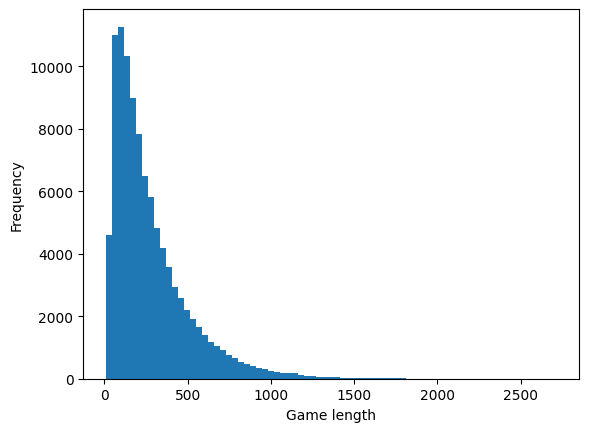

In [33]:
show_distribution(game_lengths(deck52))

The median game (in this sample) takes 224 plays, the mean is 294, and some games take thousands of plays.  